In [1]:
import sys
sys.path.append('/users/taoshi11/analysator/')
import pytools as pt
import numpy as np

Using LaTeX formatting
Using backend module://matplotlib_inline.backend_inline
Using matplotlib version 3.8.4


In [2]:
az_total = np.load('../../output/Bflux/Bconvection_rate/azimuthal_convection_rate_all_new.npy')
az_MLT = np.load('../../output/Bflux/Bconvection_rate/az_conv_MLT.npy')
Bflux_sector = np.load('../../output/Bflux/Bflux_total_MLT1h.npy')
r_total = np.load('../../output/Bflux/B_radial_conv_rate/radial_conv_rate_MLT1h.npy')

In [3]:
az_MLT.shape

(812, 25)

In [4]:
# Now calculate reconnection rate use those

reconnection_rate_MLT = Bflux_sector-r_total-az_MLT[:,1:]

In [5]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from scipy.ndimage import uniform_filter1d
from matplotlib.ticker import ScalarFormatter

In [6]:
def flux_change_rate(Bflux_total):

    Bflux0 = Bflux_total[:-1,:]
    Bflux1 = Bflux_total[1:,:]

    t0 = Bflux_total[:-1,0]
    t1 = Bflux_total[1:,0]
    delta_t = t1-t0

    rate = (Bflux1-Bflux0)/(delta_t[:,np.newaxis])
#     rate = (Bflux1-Bflux0)/(delta_t)
    return rate

In [7]:
closed_flux_change = flux_change_rate(Bflux_sector)
reconnection_rate_MLT = closed_flux_change-r_total[1:,:]-az_MLT[1:,1:]

In [8]:
reconnection_rate_MLT.shape

(811, 24)

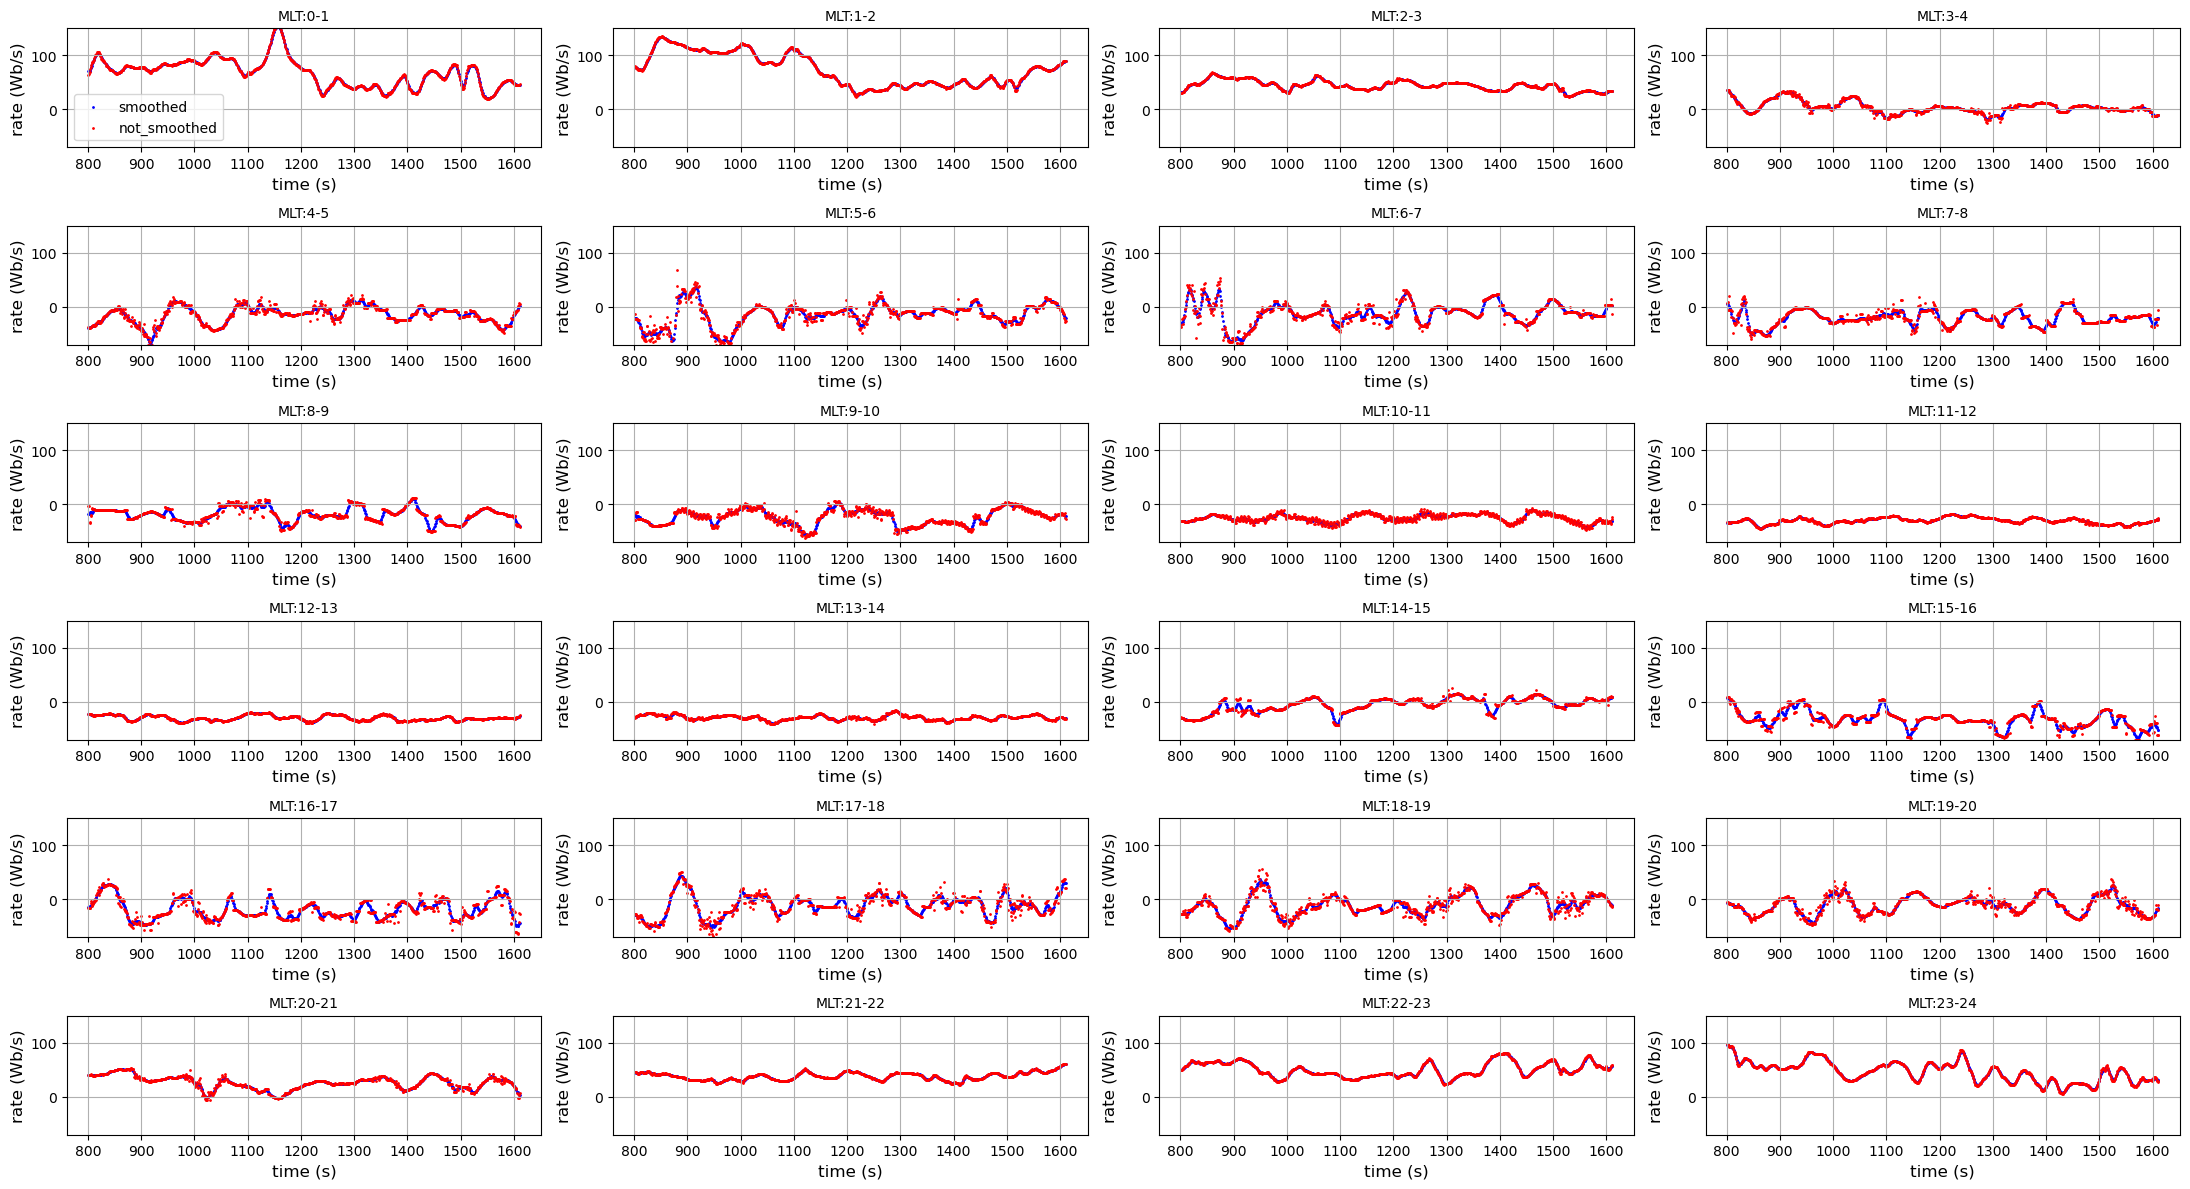

In [9]:
figure = plt.figure(figsize = (22,12))
window_size = 10
legends = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10','10-11','11-12','12-13','13-14',
          '14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-24']

Reconnection_rate_MLT = {}
for i in range(reconnection_rate_MLT.shape[1]):
    reconnection_tmp = reconnection_rate_MLT[:,i]
    time  = az_MLT[1:,0]
    reconnection_smoothed_tmp = uniform_filter1d(reconnection_tmp, size=window_size)
    
    ax = plt.subplot(6,4,(i+1))
    # plt.scatter(t1,rate_tmp,s = 1,c='r',label = 'Flux change rate')
    plt.scatter(time,reconnection_smoothed_tmp / 1e3,s = 1,c='b',label = 'smoothed')
    plt.scatter(time,reconnection_tmp / 1e3,s = 1,c='r',label = 'not_smoothed')

    Reconnection_rate_MLT[f'MLT_{legends[i].replace("-","_")}'] = reconnection_smoothed_tmp / 1e3 # unit(kV)
    
    if i == 11:
        MLT_11_12 = reconnection_smoothed_tmp
    if i == 12:
        MLT_12_13 = reconnection_smoothed_tmp
#     plt.scatter(t1,reconnection_rate[:,i],s=1,c='black',label='Reconnection rate')
#     plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='LOESS Smoothed')
    plt.xlabel('time (s)',fontsize = 12)
    plt.ylabel('rate (Wb/s)',fontsize = 12)
    plt.title(f'MLT:{legends[i]}',fontsize = 10)
    # # plt.title(f'MLT:{legends[i]}',fontsize = 14)
    plt.ylim([-70,150])
    # ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if i == 0: 
        plt.legend()

    plt.grid()

plt.tight_layout()
plt.savefig("reconnection_rate_MLT1h.png")
plt.show()
    

In [10]:
len(legends)
legends[22]
# reconnection_rate_MLT.shape[1]

'22-23'

In [11]:
Re = 6371000
points = []
MLT_hours = 24
for hour in range(MLT_hours):
    angle = 2 * np.pi * hour / MLT_hours
    x = -20 * Re * np.cos(angle)
    y = -20 * Re * np.sin(angle)
    points.append([x, y, 0])

In [12]:
# Find the MLT values for each coordinate
def get_MLT_value(coords):
    xx, yy = coords[:, 0], coords[:, 1]
    MLT_values = np.zeros((coords.shape[0]))

    for i in range(len(xx)):
        x, y = xx[i], yy[i]

        if x == 0:
            if y > 0:
                MLT = 18
            elif y < 0:
                MLT = 6
        else:
            angle = np.arctan2(y, x)
            MLT = 12 + angle * (12/np.pi)

        MLT_values[i] = MLT

    return MLT_values
# get_MLT_value(np.array(points))

In [13]:
size_phi = 100
phi = np.linspace(0,2*np.pi,size_phi)
Re = 6371000
r = 20 * Re
x, y = r * np.cos(phi), r * np.sin(phi)
points_circle = np.zeros((size_phi,3))
points_circle[:,0] = x
points_circle[:,1] = y

In [14]:
def get_MLT_value(coords):
    xx, yy = coords[:, 0], coords[:, 1]

    angles = np.arctan2(yy,xx)
    MLT_values = 12 + angles *(12/np.pi)

    MLT_values = np.where((xx == 0) & (yy > 0), 18, MLT_values)
    MLT_values = np.where((xx == 0) & (yy < 0), 6, MLT_values)


    return MLT_values


In [15]:
t = np.arange(800,1612,1)
MLTs = get_MLT_value(points_circle)

In [16]:
reconnection_rate_9_12 = np.load("reconnection_rate_MLT9_12.npy")
reconnection_rates = np.load("reconnection_rate_MLTs.npy")

In [17]:
np.all(reconnection_rates[:,3]) == np.all(reconnection_rate_9_12)

True

In [18]:
sorted_indices = np.argsort(MLTs)
sorted_MLT = MLTs[sorted_indices]
sorted_az_total = az_total[:,sorted_indices]

In [19]:
sorted_az_total.shape

(812, 100)

In [20]:
sorted_MLT

array([ 0.12121212,  0.36363636,  0.60606061,  0.84848485,  1.09090909,
        1.33333333,  1.57575758,  1.81818182,  2.06060606,  2.3030303 ,
        2.54545455,  2.78787879,  3.03030303,  3.27272727,  3.51515152,
        3.75757576,  4.        ,  4.24242424,  4.48484848,  4.72727273,
        4.96969697,  5.21212121,  5.45454545,  5.6969697 ,  5.93939394,
        6.18181818,  6.42424242,  6.66666667,  6.90909091,  7.15151515,
        7.39393939,  7.63636364,  7.87878788,  8.12121212,  8.36363636,
        8.60606061,  8.84848485,  9.09090909,  9.33333333,  9.57575758,
        9.81818182, 10.06060606, 10.3030303 , 10.54545455, 10.78787879,
       11.03030303, 11.27272727, 11.51515152, 11.75757576, 12.        ,
       12.        , 12.24242424, 12.48484848, 12.72727273, 12.96969697,
       13.21212121, 13.45454545, 13.6969697 , 13.93939394, 14.18181818,
       14.42424242, 14.66666667, 14.90909091, 15.15151515, 15.39393939,
       15.63636364, 15.87878788, 16.12121212, 16.36363636, 16.60

In [21]:
# # separate MLT sectors. 0-1, 1-2, 2-3, ..., 23-24, altogether 24
# az_conv_MLT = np.full((sorted_az_total.shape[0],24))

# for i in range(24):
#     indices_tmp = np.where((sorted_MLT>=i) and (sorted_MLT<i+1))
#     az_conv_MLT[i] = 

In [22]:
# Calculate in each 1h MLT sector
Az_conv_sector = np.full((t.shape[0],24),np.nan)
for i in range(24):
    indice_tmp = np.where((sorted_MLT >= i) & (sorted_MLT<i+1))[0]
    Az_conv_sector[:,i] = np.sum(sorted_az_total[:,indice_tmp],axis=1)

    


In [23]:
Az_conv_sector.shape

(812, 24)

In [24]:
MLTv,tv = np.meshgrid(sorted_MLT,t)

In [25]:
MLTv.shape

(812, 100)

In [26]:

t1 = np.arange(800,1611,1)
peak_t1 = [810,859,908,953,990,1034,1094,1229,1293,1405,1491,1558]
peak_indices = [np.where(t1 == peak)[0][0] for peak in peak_t1]

In [27]:
reconnection_rate_9_12[peak_indices[0]]

98494.88009549178

In [28]:
t1[peak_indices]

array([ 810,  859,  908,  953,  990, 1034, 1094, 1229, 1293, 1405, 1491,
       1558])

In [29]:
np.max(reconnection_rate_9_12[1:20])

98494.88009549178

In [30]:
t_selected = t[peak_indices]
MLT_selected = [10.5]* t_selected.shape[0]

In [31]:
MLT_selected

[10.5, 10.5, 10.5, 10.5, 10.5, 10.5, 10.5, 10.5, 10.5, 10.5, 10.5, 10.5]

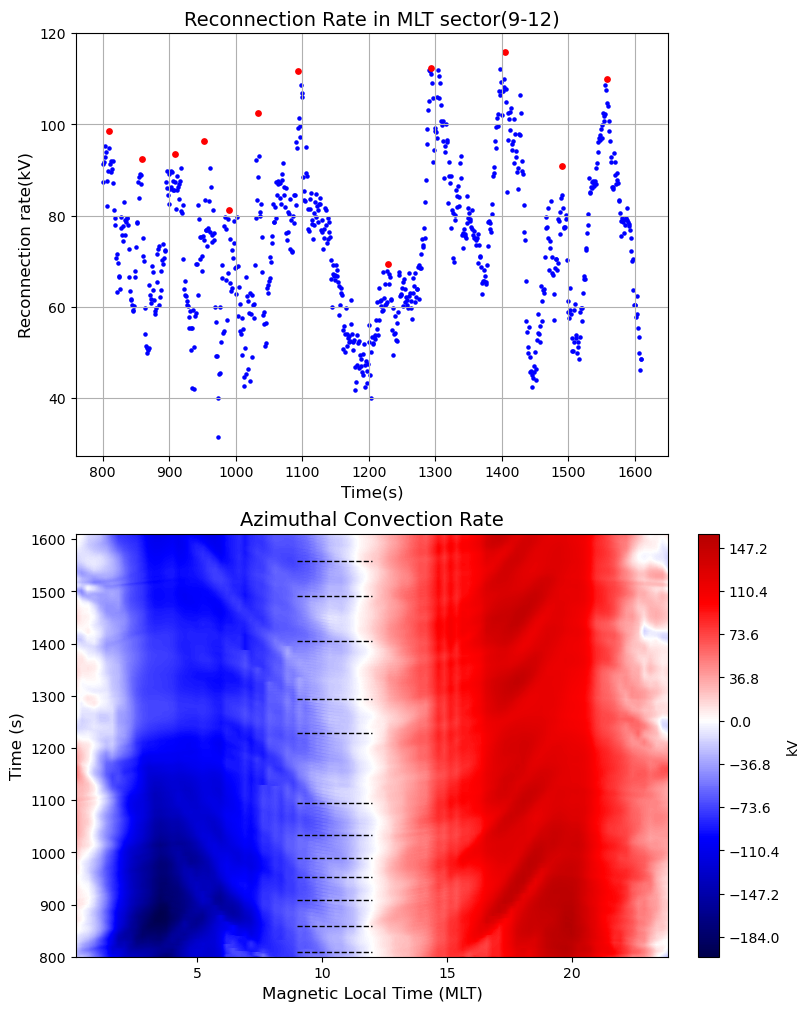

In [32]:
# %matplotlib notebook
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), constrained_layout=True)
# ax1 = fig.add_subplot(211)

t1 = np.arange(800,1611,1)

ax1.scatter(t1, reconnection_rate_9_12 / 1e3, s=5, c='b')
ax1.scatter(t1[peak_indices],reconnection_rate_9_12[peak_indices]/1e3,c='r',s=15)
ax1.set_title("Reconnection Rate in MLT sector(9-12)",fontsize=14)
ax1.set_xlabel("Time(s)",fontsize=12)
ax1.set_ylabel("Reconnection rate(kV)",fontsize=12)
ax1.grid(True)
# ax2 = fig.add_subplot(212)
ax2.set_facecolor("lightgrey")


vmax1 = np.max(np.abs(sorted_az_total)) / 1e3
vmin1 = -vmax1

vcenter = 0
norm1 = mcolors.TwoSlopeNorm(vmin=vmin1, vcenter=vcenter, vmax=vmax1)

contour_plot = ax2.contourf(MLTv, tv, sorted_az_total/1e3,levels = 500,norm = norm1,cmap='seismic') 


colorbar = plt.colorbar(contour_plot,ax=ax2)
colorbar.set_label('kV')
# colorbar = fig.colorbar(contour_plot, ax=[ax1, ax2], location='right', shrink=0.8, aspect=40, pad=0.02)
# colorbar.set_label('kV')


for j in range(len(MLT_selected)):
    # Converting MLT data values to axis fraction
    xmin_frac = (MLT_selected[j] - 1.5 - ax2.get_xlim()[0]) / (ax2.get_xlim()[1] - ax2.get_xlim()[0])
    xmax_frac = (MLT_selected[j] + 1.5 - ax2.get_xlim()[0]) / (ax2.get_xlim()[1] - ax2.get_xlim()[0])

    # Draw horizontal lines if within valid range
    if 0 <= xmin_frac <= 1 and 0 <= xmax_frac <= 1:
        ax2.axhline(y = t_selected[j], xmin=xmin_frac, xmax=xmax_frac, linewidth=1,color='black', linestyle='dashed')


ax2.set_title('Azimuthal Convection Rate', fontsize = 14)
ax2.set_xlabel('Magnetic Local Time (MLT)',fontsize=12)
ax2.set_ylabel('Time (s)',fontsize = 12)

# plt.scatter(t1[peak_indices],reconnection_rate_9_12[peak_indices]/1e3,s=10,c='y')
# plt.tight_layout()
# plt.savefig('../../output/MLT_9_12_azimuthal.png')
plt.show()

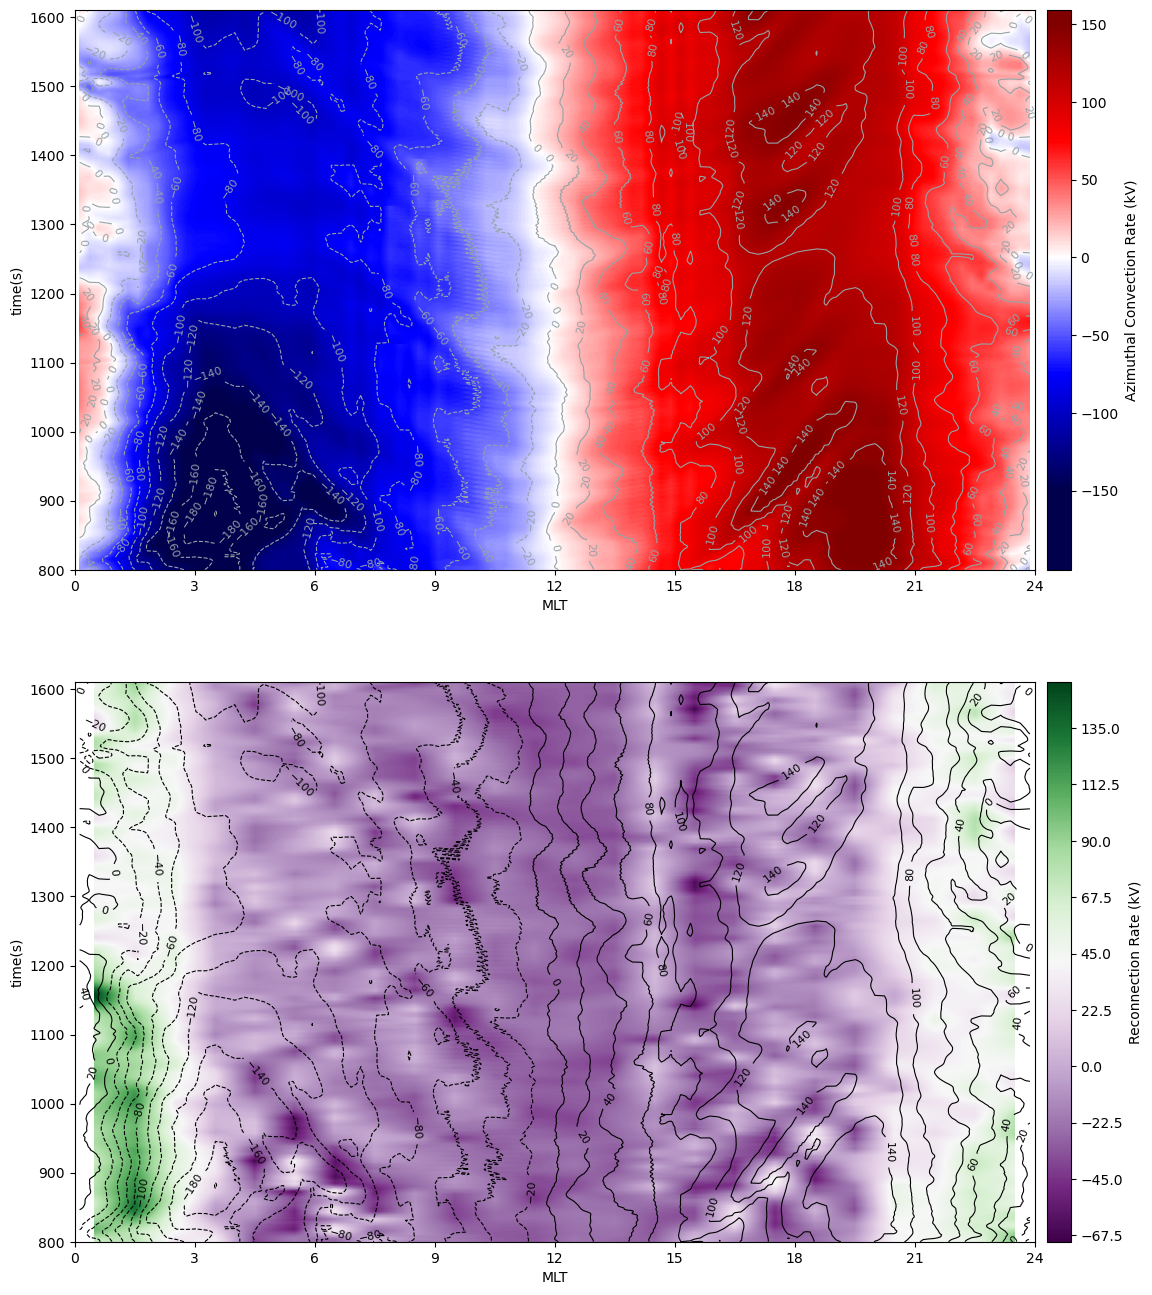

In [33]:
from matplotlib.colors import SymLogNorm
from matplotlib.colors import TwoSlopeNorm
# from matplotlib.colors import DivergingNorm

fig2 = plt.figure(figsize = (12,16))
ax4 = fig2.add_subplot(211)
t1 = np.arange(800,1611,1)
# vmax1 = np.max(np.abs(sorted_az_total)) / 1e3
# vmin1 = -vmax1

vcenter = 0
# norm1 = mcolors.TwoSlopeNorm(vmin=vmin1, vcenter=vcenter, vmax=vmax1)

norm1 = mcolors.TwoSlopeNorm(vmin=-150, vcenter=vcenter, vmax=150)

contour_plot = ax4.contourf(MLTv, tv, sorted_az_total/1e3,levels = 500,norm = norm1,cmap='seismic')
contour_plot.set_clim(-150,150)

cax1 = fig2.add_axes([0.91, 0.53, 0.02, 0.35]) 
colorbar1 = plt.colorbar(contour_plot,ax=ax4,cax = cax1, ticks = [-150,-100,-50,0,50,100,150])


custom_levels = [-180, -160, -140, -120, -100, -90, -80, -60, -40, -20, 20, 40, 60, 80, 100, 120, 130, 140, 160, 170]
contour_lines1 = ax4.contour(MLTv, tv, sorted_az_total/1e3, levels= 20, colors='xkcd:cool grey', linewidths=0.8)
ax4.clabel(contour_lines1, inline=True, fontsize=8)

# contour_lines2 = ax4.contour(MLT_re_v, t_re_v, levels= 25, colors='yellow', linewidths=0.8)
ax4.clabel(contour_lines1, inline=True, fontsize=8)


# colorbar1.set_ticks([-150,150])
colorbar1.set_label('Azimuthal Convection Rate (kV)')
ax4.set_xticks([0,3,6,9,12,15,18,21,24])
ax4.set_xlabel('MLT')
ax4.set_ylabel('time(s)')

# zs = np.concatenate([reconnection_rate_9_12 / 1e3,reconnection_rate_12_15 / 1e3, np.abs(reconnection_rate_0_3/1e3)
                    # , np.abs(reconnection_rate_21_0/1e3)], axis =0)
# zs = np.concatenate([reconnection_rate_9_12 / 1e3,reconnection_rate_12_15 / 1e3])

# all_values = np.concatenate(list(Reconnection_rate_MLT.values()))

# max_ = all_values.max()
# min_ = all_values.min()


# ij = 0
# for key, value in Reconnection_rate_MLT.items():

#     reco_rate_tmp = value
#     scatter_plot_tmp = ax4.scatter([(2*ij + 1)/2] * t1.shape[0], t1, c = reco_rate_tmp, s = 5, cmap = 'PRGn',
#                                    norm = TwoSlopeNorm(vmin = min_, vcenter = 0, vmax = max_))
#     scatter_plot_tmp.set_clim(min_, max_)
#     # scatter_plot_tmp.set_clim(10,50)
#     ij += 1
    



# cax2 = fig2.add_axes([0.002, 0.15, 0.02, 0.7])



# colorbar2 = plt.colorbar(scatter_plot_tmp,cax = cax2)

# ticks = [-50, -20, -10, 0, 10, 20, 50]
# colorbar2.set_ticks(ticks)

# colorbar2.ax.minorticks_on()

# colorbar2.set_label('Reconnection Rate (kV)',labelpad=-70, y=0.45)

MLT_re = np.arange(0.5,24.5,1)
t_re = np.arange(801,1612)

MLT_re_v, t_re_v = np.meshgrid(MLT_re, t_re)
Reconnection_rate_array = np.array(list(Reconnection_rate_MLT.values())).T


ax5 = fig2.add_subplot(212)
contour_plot2 = ax5.contourf(MLT_re_v, t_re_v, Reconnection_rate_array,levels = 500,cmap='PRGn')
# contour_lines = ax5.contour(MLT_re_v, t_re_v, Reconnection_rate_array, levels= 25, colors='black', linewidths=0.8)
contour_lines2 = ax5.contour(MLTv, tv, sorted_az_total/1e3, levels= 20, colors='black', linewidths=0.8)
ax5.clabel(contour_lines2, inline=True, fontsize=8)

ax5.clabel(contour_lines1, inline=True, fontsize=8)
cax5 = fig2.add_axes([0.91, 0.11, 0.02, 0.35]) 
colorbar5 = plt.colorbar(contour_plot2,ax=ax5,cax = cax5)

colorbar5.set_label('Reconnection Rate (kV)')
ax5.set_xticks([0,3,6,9,12,15,18,21,24])
ax5.set_xlabel('MLT')
ax5.set_ylabel('time(s)')
# colorbar5 = figure5.colorbar(contour_plot2)

fig2.subplots_adjust(left=0.1, right = 0.9)
# plt.savefig("Az_conv_with_reconnection.png")

# fig2.subplots_adjust(left=0.01)


plt.show()

In [34]:
f.read_variable("ig_E")

NameError: name 'f' is not defined

In [ ]:
Reconnection_rate_array = np.array(list(Reconnection_rate_MLT.values())).T

In [ ]:
Reconnection_rate_array.shape
MLT_re = np.arange(0.5,23.5,1)
t_re = np.arange(801,1612)

MLT_re_v, t_re_v = np.meshgrid(MLT_re, t_re)

In [ ]:
figure5 = plt.figure(figsize = (12,8))
ax5 = figure5.add_subplot(111)
contour_plot2 = ax5.contourf(MLT_re_v, t_re_v, Reconnection_rate_array,levels = 500,cmap='PRGn')
contour_lines = ax5.contour(MLT_re_v, t_re_v, Reconnection_rate_array, levels= 40, colors='black', linewidths=0.8)

ax5.clabel(contour_lines, inline=True, fontsize=8)
colorbar5 = figure5.colorbar(contour_plot2)

plt.show()

In [ ]:
type(ax5)

In [ ]:
reconnection_rate_12_15 = reconnection_rates[:,4]
plt.scatter([10.5]*t1.shape[0], t1, c=reconnection_rate_9_12 / 1e3, s=5, cmap='viridis')
plt.scatter([13.5]*t1.shape[0], t1, c=reconnection_rate_12_15 / 1e3, s=5, cmap='viridis')
zs = np.concatenate([reconnection_rate_9_12 / 1e3,reconnection_rate_12_15 / 1e3], axis =0)
min_,max_ = zs.min(), zs.max()
plt.clim(min_,max_)

cbar = plt.colorbar(label = 'Reconnection Rate (kV)')
# cbar.set_ticks([''])
plt.show()

In [ ]:
reconnection_rate_6_9 = reconnection_rates[:,2]
reconnection_rate_15_18 = reconnection_rates[:,5]
reconnection_rate_0_3 = reconnection_rates[:,0]
reconnection_rate_21_0 = reconnection_rates[:,-1]

In [ ]:
# plt.scatter(t1,reconnection_rate_0_3/1e3, c='b')
plt.scatter(t1,reconnection_rate_12_15/1e3,c = 'r',s = 5,label = '12-15')
plt.scatter(t1,reconnection_rate_9_12/1e3,c = 'g',s = 5,label = '9-12')
# plt.scatter(t1,np.abs(reconnection_rate_21_0/1e3),c = 'g')
plt.legend()
plt.show()

In [ ]:
plt.scatter([10.5]*t1.shape[0], t1, s=reconnection_rate_9_12 / 1e4, c = 'black')
# plt.colorbar(label = 'Reconnection Rate MLT9-12')
plt.show()

In [ ]:
# %matplotlib notebook
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors


fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.set_facecolor("lightgrey")

# vmin1 = sorted_az_total.min()/1e3
# # vmax1 = -vmin1
# vmax1 = sorted_az_total.max()/1e3

vmax1 = np.max(np.abs(sorted_az_total)) / 1e3
vmin1 = -vmax1

vcenter = 0
norm1 = mcolors.TwoSlopeNorm(vmin=vmin1, vcenter=vcenter, vmax=vmax1)

contour_plot = ax1.contourf(MLTv, tv, sorted_az_total/1e3,levels = 500,norm = norm1,cmap='seismic') 
# contour_plot = ax1.contourf(tv, MLTv, sorted_az_total/1e3,levels = 500,norm = norm1,cmap='seismic') 
# ax1.set_colorbar(contour_plot)

colorbar = plt.colorbar(contour_plot,ax=ax1)
colorbar.set_label('kV')

# ticks = np.linspace(vmin1, vmax1, num=10)
# colorbar.set_ticks(ticks)

ax1.set_title('Azimuthal Convection Rate')
ax1.set_xlabel('Magnetic Local Time (MLT)')
ax1.set_ylabel('Time (s)')

# plt.savefig("../../output/Bflux/Bflux_change_rate/Bflux_change_rate_vs_convection_rate.png")
# def motion(event):
#     if event.inaxes is not None:
#         txt.set_text('x={:.2f}, y={:.2f}'.format(event.xdata, event.ydata))
#         txt.set_position((event.xdata, event.ydata))
#         fig.canvas.draw()

# # Connect the motion_notify_event to the motion function
# fig.canvas.mpl_connect('motion_notify_event', motion)

# ax1.scatter(MLT_selected,t_selected,s=4,c = 'black')


# for j in range(len(MLT_selected)):
#     ax1.axhline(y = t_selected[j], xmin = MLT_selected[j]-1.5, xmax = MLT_selected[j]+1.5, linewidth = 2)

for j in range(len(MLT_selected)):
    # Converting MLT data values to axis fraction
    xmin_frac = (MLT_selected[j] - 1.5 - ax1.get_xlim()[0]) / (ax1.get_xlim()[1] - ax1.get_xlim()[0])
    xmax_frac = (MLT_selected[j] + 1.5 - ax1.get_xlim()[0]) / (ax1.get_xlim()[1] - ax1.get_xlim()[0])

    # Draw horizontal lines if within valid range
    if 0 <= xmin_frac <= 1 and 0 <= xmax_frac <= 1:
        ax1.axhline(y = t_selected[j], xmin=xmin_frac, xmax=xmax_frac, linewidth=1,color='black', linestyle='dashed')

# plt.savefig('../../output/Bflux/azimuthal_convection_rate.png')
plt.show()


In [ ]:
print(f"vmin: {vmin1}, vmax: {vmax1}")

In [ ]:
t_selected = t[np.array([12,35,57,163,235,299,600,692,761])]


In [ ]:
t.shape

In [ ]:
MLT_selected = [10.5]* t_selected.shape[0]
MLT_selected

In [ ]:
np.where(az_total<0)[0].shape

In [ ]:
np.where(az_total>0)[0].shape

In [ ]:
az_total.min()

In [ ]:
az_total.max()

In [ ]:
vmin1

In [ ]:
vmin1/2

In [ ]:
az_total.shape

In [ ]:
np.arange(1150,1151,1)

In [ ]:
t[350]

In [ ]:
az_total[350,:]

In [ ]:
MLTv[0]

In [ ]:
MLTs.sort()
MLTs